# Table of Contents
* [Setup](#Setup)
	* [estimate cost](#estimate-cost)
	* [load dataset](#load-dataset)
* [Submitting HITs](#Submitting-HITs)
* [Retrieve results](#Retrieve-results)
* [Interact with workers](#Interact-with-workers)
* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2


import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)


import re
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
import random
from tqdm import tqdm

from IPython.core.display import HTML

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo


from amt_utils.mturk import MTurk
from amt_utils.mturk import pickle_this, unpickle_this

# Setup

## estimate cost

In [2]:
cost_per_hit = 0.04
n_turkers_per_hit = 3
n_hits_per_video = 3

n_videos_low = 200
n_videos_high = 50000

low = cost_per_hit * n_turkers_per_hit * n_videos_low * n_hits_per_video
high = cost_per_hit * n_turkers_per_hit * n_videos_high * n_hits_per_video
print(str(low) + ' - $' + str(high))

72.0 - $18000.0


## load dataset

In [73]:
# s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/subtask_frames/'


# data_file_path = '../../build_dataset/ds_interface_bonus_skeleton.json'

# with open(data_file_path, 'r') as f:
#     ds_skeleton = json.load(f)

# stills_to_annotate = []
# for clip in ds_skeleton:
#     for still in clip['keyFrames']:
#         stills_to_annotate.append(still)
# len(stills_to_annotate)

In [116]:
# subtask_stills = unpickle_this('subtask_stills_8.pkl')
subtask_stills = unpickle_this('prod_1_4_subtask.pkl')

In [117]:
len(subtask_stills)

18154

# Submitting HITs

In [2]:
from amt_utils.flintstones import prepare_hit
from amt_utils.flintstones import prepare_simpler_hit
from amt_utils.flintstones import write_task_page
from amt_utils.flintstones import generate_simpler_task_page

from amt_utils.mturk import expected_cost

In [3]:
turk_account = mturk_ai2
rw_host='mechanicalturk.amazonaws.com'
amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key, host=rw_host)
# amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key)
amt_con.get_account_balance()

$0.06

In [130]:
subtask_params = {
    'title': 'Annotate characters from an animation frame',
    'description': 'Draw a bounding box for a character in a image.',
    'keywords': ['animation', 'image', 'bounding box','bounding boxes', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.02,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
}

In [134]:
# build_hit_group = []
# for img_id, n_chars in tqdm(subtask_stills.items()):
#     build_hit_group.extend(prepare_simpler_hit(s3_base_path, img_id, n_chars, subtask_params))
# write_task_page(build_hit_group[0]['html'])

In [120]:
len(build_hit_group)

29093

In [132]:
expected_cost(build_hit_group, subtask_params, amt_con)

Insufficient Funds


62.52

**Procedure**

1. assure interface template is working

2. build and load ds skeleton for the sample to be submitted

3. make sure to sync images to s3

4. double check static params and host

5. build and submit

In [127]:
hit_group = [amt_con.create_html_hit(single_hit) for single_hit in tqdm(build_hit_group)]

 95%|█████████▌| 27672/29093 [1:30:56<05:10,  4.58it/s]  

MTurkRequestError: MTurkRequestError: 200 OK
<?xml version="1.0"?>
<CreateHITResponse><OperationRequest><RequestId>166329a1-4f39-4c17-84f1-21180d5f25ab</RequestId></OperationRequest><HIT><Request><IsValid>False</IsValid><Errors><Error><Code>AWS.MechanicalTurk.InsufficientFunds</Code><Message>This Requester has insufficient funds in their account to complete this transaction. Please visit https://requester.mturk.com/prepayments/new to purchase Prepaid HITs. (1502770981547)</Message><Data><Key>RequiredFunds</Key><Value>5943570</Value></Data><Data><Key>CurrentFunds</Key><Value>5943540</Value></Data><Data><Key>RequiredFunds</Key><Value>5943570</Value></Data></Error></Errors></Request></HIT></CreateHITResponse>

last frame 27672/29093

# Retrieve results

In [6]:
# from amt_utils.flintstones import get_assignments
from amt_utils.flintstones import filter_hits_by_date
from amt_utils.flintstones import filter_hits_by_completion
from amt_utils.flintstones import filter_hits_by_status
from amt_utils.flintstones import get_completed_hits
from amt_utils.flintstones import get_assignments
from amt_utils.mturk import pickle_this

In [7]:
import datetime
import dateutil.parser as dt_parse

In [5]:
%%time

all_hits = amt_con.get_reviewable_hits(detailed=False)

CPU times: user 1.97 s, sys: 139 ms, total: 2.11 s
Wall time: 5min 52s


In [10]:
len(all_hits)

63216

In [11]:
pickle_this(all_hits, 'rev_hits_8_15.pkl')

In [ ]:
step_size = 10000

In [9]:
hit_g1= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[:10000])]

100%|██████████| 10000/10000 [18:55<00:00,  8.80it/s] 


In [ ]:
hit_g2= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size:step_size*2])]

In [ ]:
hit_g3= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size *2:step_size*3])]

In [ ]:
hit_g4= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size *3:step_size*4])]

In [ ]:
hit_g5= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size *4:step_size*5])]

In [ ]:
hit_g6= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size *5:step_size*6])]

In [ ]:
hit_g7= [amt_con.connection.get_hit(hit.HITId) for hit in tqdm(all_hits[step_size *6:])]

In [ ]:
flattened_list = [item for sublist in l for item in sublist]

In [16]:
latest_hits_2 = unpickle_this('latest_hit_group_2.pkl')
latest_hits_rest = unpickle_this('latest_hit_group.pkl')
latest_hits_2

In [34]:
combined_latest_hits = [ch[0] for ch in hit_g1] + [ch[0] for ch in latest_hits_2] + [ch[0] for ch in latest_hits_rest]

In [22]:
th1 = combined_latest_hits[-1]

In [35]:
len(combined_latest_hits)

63216

In [36]:
th1 = all_hits[0]

In [38]:
start_date = (2017, 8, 15)
end_date = (2017, 8, 16)
recent_hits = filter_hits_by_date(combined_latest_hits, start_date, end_date)
# recent_hits = filter_hits_by_status(recent_hits)

In [39]:
len(recent_hits)

29633

In [43]:
creation_times = pd.Series([dt_parse.parse(hit.CreationTime) for hit in filter_hits_by_date(recent_hits, (2017, 8, 9), (2017, 8, 16))])

In [61]:
bonus_hits = [hit for hit in all_hits if 'bonus' in hit.Title]

In [68]:
subtask_hits = [hit for hit in all_hits if hit.FormattedPrice == u'$0.01']

In [69]:
len(subtask_hits)

1088

In [55]:
th1 = all_hits[0]

In [66]:
th1.FormattedPrice

u'$0.05'

In [54]:
len(subtask_hits)

1632

In [49]:
len(all_hits)

13671

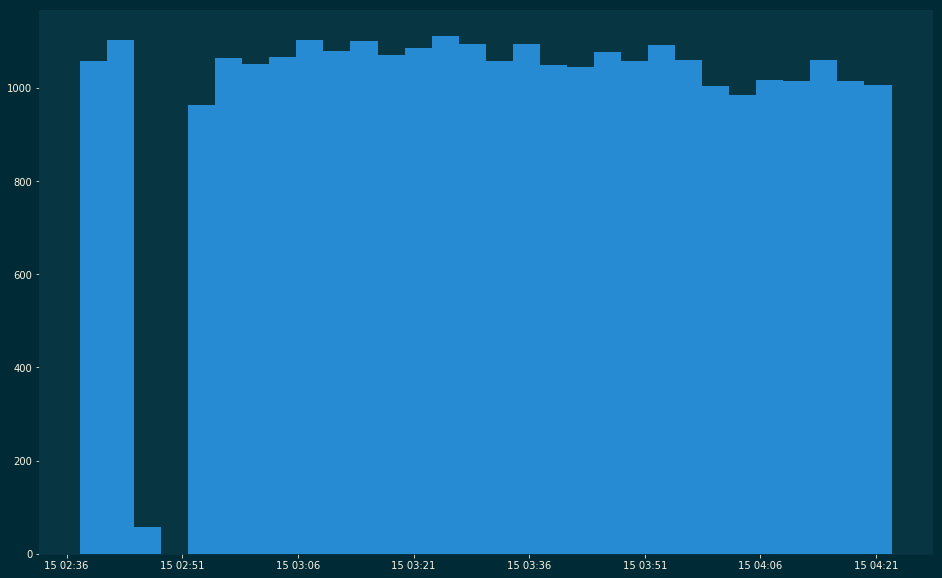

In [44]:
_ = creation_times.hist(bins = 30)

In [ ]:
results = get_assignments(amt_con.connection, tqdm(recent_hits))

 17%|█▋        | 4890/29633 [08:59<46:57,  8.78it/s]  

In [60]:
pickle_this(results, 'turker_all_subtask_8_12.pkl')

In [103]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [107]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# Interact with workers

## reject assignments and ban workers

In [32]:
def ban_bad_workers(mturk_connection, worker_ids):
    for worker in worker_ids:
        reason_for_block = """
        Your HITs contained many incorrect character descriptions.
        """
        print('blocking ' + str(worker))
        mturk_connection.block_worker(worker, reason_for_block)

In [13]:
workers_to_ban = 'A300BK2S2PO3Q7'

In [33]:
ban_bad_workers(amt_con.connection, [workers_to_ban])

blocking A300BK2S2PO3Q7


In [14]:
to_reject = unpickle_this('to_reject.pkl')

In [15]:
def reject_assignments(mturk_connection, assignments_to_reject):
    feedback_message = """
    Your HITs contained many incorrect character descriptions.
    """
    reject_count = len(assignments_to_reject)
    for assignment_id in assignments_to_reject:
        try:
            mturk_connection.reject_assignment(assignment_id, feedback_message)
        except boto.mturk.connection.MTurkRequestError:
            print('assignment ' + str(assignment_id) + ' already accepted or rejected')

    return reject_count

In [31]:
reject_assignments(amt_con.connection, to_reject)

assignment 37Q970SNZF81C57Q82CTMS6JCZ11S0 already accepted or rejected
assignment 3ATTHHXXWBOK8SPNAJ3MDZ4X8GDXIV already accepted or rejected


150

## pay bonuses

In [16]:
subject = "More  HITs are available"
message = """
Hello, 

"""

In [15]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

In [46]:
bonuses = unpickle_this('bonuses_to_pay_2.pkl')

In [ ]:
sum(bonuses.values()) * 0.01

In [38]:
sum(bonuses.values()) * 0.01

18.94

In [53]:
def pay_bonuses(bonuses_to_pay):
    total_payed = 0
    bonus_reason_template = 'For Flinstones character labels written.'
    for aid, vals in tqdm(bonuses_to_pay.items()):
        n_chars = vals['count']
        wid = vals['worker_id']
        bonus_ammount = boto.mturk.price.Price(0.01 * n_chars)
        total_payed += bonus_ammount.amount
        bonus_reason = bonus_reason_template
        amt_con.connection.grant_bonus(wid, aid, bonus_ammount, bonus_reason)
    return total_payed

In [54]:
pay_bonuses(bonuses)

100%|██████████| 1306/1306 [05:30<00:00,  4.12it/s]


18.939999999999987

# Accepting and deleting HITs

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [19]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

len(assignments)

6222

In [20]:
assignments_to_accept = [asgmt for asgmt in assignments if asgmt.AssignmentId not in to_reject]

In [21]:
len(assignments_to_accept)

6072

In [27]:
e_count = 0
for assignment in tqdm(assignments_to_accept):
    try:
        amt_con.approve_assignment(assignment)
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 6072/6072 [24:11<00:00,  4.72it/s]   


In [ ]:
# _ = [amt_con.disable_hit(hit) for hit in hits_today]

In [ ]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [147]:
amt_con.get_account_balance()

$10,000.00

In [525]:
amt_con.delete_all_hits()